In [8]:
import numpy as np
import numpy.linalg as la
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import sys
import math
import inspect

In [9]:
class ProgressBar:
    __slots__ = ['description', 'overall', 'done', 'prevp', 'len', 'closed']
    def __init__(self, description, overall):
        self.description = description
        self.overall = overall
        self.done = 0
        self.prevp = -1
        self.len = 40
        self.closed = False
        self.__show()
    def go(self):
        self.done += 1
        self.__show()
    def __show(self):
        p100 = int(round(100.0 * self.done / self.overall))
        if p100 > self.prevp:
            p = int(round(self.len * self.done / self.overall))
            print("\r%s: [%s%s] %d%%" % (self.description, '#' * p, '.' * (self.len - p), p100), end='')
            self.prevp = p100
            if p == self.len:
                self.close()
    def close(self):
        if not self.closed:
            self.closed = True
            print()


In [10]:
def InitializeDataset(name):
    dataset = pd.read_csv(name)
    return dataset.values

Dataset = InitializeDataset('chips.txt')

In [40]:
__Metrics = [lambda x, y : la.norm(x - y),
           lambda x, y : la.norm(x - y, ord = 1),
           lambda x, y : la.norm(x - y, ord = np.inf)]
def QueryMetric(mInd, tInd):
    if tInd == 0:
        trans = lambda x, y: np.array([x, y])
    elif tInd == 1:
        trans = lambda x, y: np.array([x - y, x + y])
    elif tInd == 2:
        trans = lambda x, y: np.array([3 * x + 2 * y, x])
    elif tInd == 3:
        trans = lambda x, y: np.array([math.sqrt(x ** 2 + y ** 2), math.atan2(x, y)])
    def ret(x, y):
        x = trans(x[0], x[1])
        y = trans(y[0], y[1])
        return __Metrics[mInd](x, y)
    return ret


In [41]:
def GetKNearest(u, objects, k, Ro):
    values = np.apply_along_axis(lambda x : Ro(u, x[:2]), 1, objects)
    result = objects[np.argsort(values)]
    return result[:k], result[k]

In [42]:
def Partition(dataset, blockSize):
    np.random.shuffle(dataset)
    ret = []
    cnt = dataset.shape[0] // blockSize
    last = 0
    for i in range(cnt):
        c = (dataset.shape[0] + i) // cnt
        ret.append(dataset[last : last + c])
        last += c
    ret = np.array(ret)
    return cnt, ret
    
def KnnClassificator(trainObjects, labelSet, metricIndex, transIndex):
    BlockSize = 29
    T = 5
    Ro = QueryMetric(metricIndex, transIndex)
    def Classificator(trainObjects, labelSet, metricIndex, k):
        def InnerClassificator(u):
            kNearest, afterKNearest = GetKNearest(u, trainObjects, k, Ro)
            labels = {label: 0 for label in labelSet}
            for object in kNearest:
                FiniteKernel = lambda x : 1 / x
                labels[object[2]] += 1 * FiniteKernel(Ro(u, object[:2]) / (Ro(u, afterKNearest[:2])))
            return max(labels.items(), key=lambda t: t[1])[0]
        return InnerClassificator
    k = -1
    prevValue = 0
    pbar = ProgressBar('Choose best k', BlockSize)
    for l in range(1, BlockSize + 1):
        # print("Try new k = %i:" % (l), end='')
        curValue = 0
        for t in range(0, T):
            q, partitions = Partition(trainObjects, BlockSize)
            for i in range(0, len(partitions)):
                training_set = []
                for j in range(len(partitions)):
                    if i != j:
                        training_set.extend(partitions[j])
                training_set = np.array(training_set)
                classificator = Classificator(training_set, labelSet, metricIndex, l)
                for p in partitions[i]:
                    trueAnswer = p[2]
                    realAnswer = classificator(p[:2])
                    if (realAnswer != trueAnswer):
                        curValue += 1
        curValue /= T * q
        # print(" score = %f" % (curValue))
        if (k == -1 or prevValue > curValue):
            k = l
            prevValue = curValue
        pbar.go()
    pbar.close()
    print("Best k is %i with score %f" % (k, prevValue))
    return k, Classificator(trainObjects, labelSet, metricIndex, k)

In [43]:
k, classificator = KnnClassificator(Dataset, [0, 1], 2, 3)

Choose best k: [########################################] 100%
Best k is 3 with score 9.250000


In [44]:
points = Dataset[:, : 2]
classes = Dataset[:, 2]
h = .01
x_min, x_max = points[:, 0].min() - 0.2, points[:, 0].max() + 0.2
y_min, y_max = points[:, 1].min() - 0.2, points[:, 1].max() + 0.2
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

test = np.c_[xx.ravel(), yy.ravel()]

totalCount = test.shape[0]

result = np.array([])
pbar = ProgressBar('Apply classificator', totalCount)
for x in test:
    result = np.append(result, classificator(x))
    pbar.go()
pbar.close()
result = result.reshape(xx.shape)

Apply classificator: [########################################] 100%


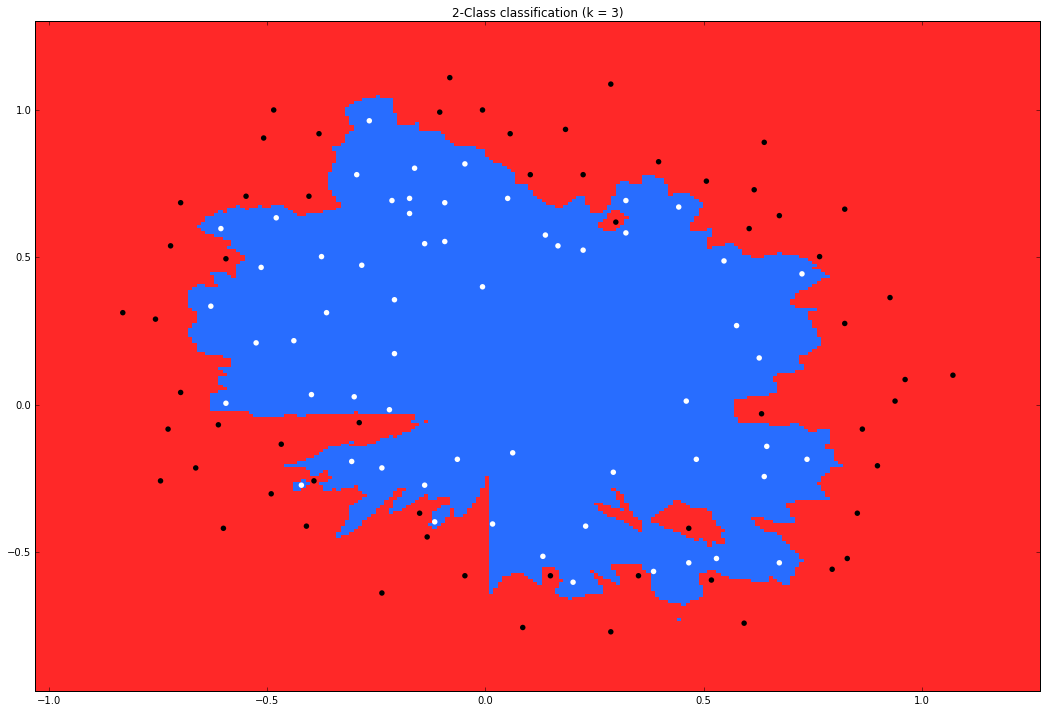

In [46]:
cmap_light = ListedColormap(['#ff2828', '#286dff'])
# cmap_bold = ListedColormap(['#a50000', '#0c00a5'])
cmap_bold = ListedColormap(['#000000', '#ffffff'])
plt.figure()
plt.rcParams["figure.figsize"] = list(map(lambda x: x * 3, plt.rcParams["figure.figsize"]))
plt.pcolormesh(xx, yy, result, cmap=cmap_light)
plt.scatter(points[:, 0], points[:, 1],  c = classes,cmap=cmap_bold, 
            linewidths=0, s=30)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("2-Class classification (k = %i)" % (k))
plt.show()